# 3. Slug Test for Confined Aquifer - Multi-well Example
**This test is taken from examples of AQTESOLV.**

## Step 1. Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3]
import pandas as pd
from ttim import *

## Introduction and Conceptual Model

In this notebook, we reproduce the work of Yang (2020) to check the TTim performance in analysing slug-test. We later compare the solution in TTim with the KGS analytical model (Hyder et al. 1994) implemented in AQTESOLV (Duffield, 2007) and to the MLU model (Carlson & Randall, 2012).

This Slug Test was reported in Butler (1998). A well (Ln-2) fully penetrates a sandy confined aquifer, with 6.1 m thickness. Additionally, an observation well (Ln-3) is placed 6.45 m away from the test well. The observation well is also fully penetrated.

The slug displacement is 2.798 m. Head change has been recorded at the slug well and the observation well. The well and casing radii of the slug well are 0.102 and 0.051 m, respectively. For the observation well, they are 0.051 and 0.025 m, respectively.

The conceptual model can be seen in the figure below.


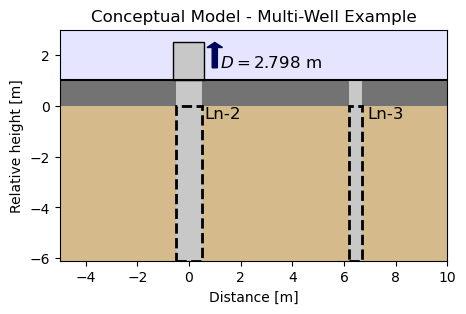

In [2]:
import matplotlib.pyplot as plt
import numpy as np

##Now printing the conceptual model figure:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# sky
sky = plt.Rectangle((-5, 1), width=15, height=3, fc="b", zorder=0, alpha=0.1)
ax.add_patch(sky)

# Aquifer:
ground = plt.Rectangle(
    (-5, -6.1),
    width=15,
    height=6.1,
    fc=np.array([209, 179, 127]) / 255,
    zorder=0,
    alpha=0.9,
)
ax.add_patch(ground)

well = plt.Rectangle(
    (-0.5, -(6.1)), width=1, height=(7.1), fc=np.array([200, 200, 200]) / 255, zorder=1
)
ax.add_patch(well)

# Confining Unit
conf = plt.Rectangle(
    (-5, 0), width=15, height=1, fc=np.array([100, 100, 100]) / 255, zorder=0, alpha=0.9
)
ax.add_patch(conf)

# Wellhead
wellhead = plt.Rectangle(
    (-0.6, 1),
    width=1.2,
    height=1.5,
    fc=np.array([200, 200, 200]) / 255,
    zorder=2,
    ec="k",
)
ax.add_patch(wellhead)

# Screen for the well:
screen = plt.Rectangle(
    (-0.5, -(6.1)),
    width=1,
    height=6.1,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen.set_linewidth(2)
ax.add_patch(screen)
pumping_arrow = plt.Arrow(x=1, y=1.5, dx=0, dy=1, color="#00035b")
ax.add_patch(pumping_arrow)
ax.text(x=1.2, y=1.5, s=r"$ D = 2.798$ m", fontsize="large")

# Piezometer
piez = plt.Rectangle(
    (6.20, -(6.1)),
    width=0.5,
    height=(7.1),
    fc=np.array([200, 200, 200]) / 255,
    zorder=1,
)
ax.add_patch(piez)
screen_piez = plt.Rectangle(
    (6.2, -(6.1)),
    width=0.5,
    height=6.1,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen_piez.set_linewidth(2)
ax.add_patch(screen_piez)

# last line
line = plt.Line2D(xdata=[-200, 1200], ydata=[1, 1], color="k")
ax.add_line(line)

# Water table
# wt = plt.Line2D(xdata= [-200,1200], ydata = [0,0], color = "b")
# ax.add_line(wt)

ax.text(0.6, -0.5, s="Ln-2", fontsize="large")
ax.text(6.9, -0.5, "Ln-3", fontsize="large")
ax.set_xlim([-5, 10])
ax.set_ylim([-6.1, 3])
ax.set_xlabel("Distance [m]")
ax.set_ylabel("Relative height [m]")
ax.set_title("Conceptual Model - Multi-Well Example");

## Step 2. Set basic parameters

In [3]:
H0 = 2.798  # initial displacement in m
b = -6.1  # aquifer thickness
rw1 = 0.102  # well radius of Ln-2 Well
rw2 = 0.071  # well radius of observation Ln-3 Well
rc1 = 0.051  # casing radius of Ln-2 Well
rc2 = 0.025  # casing radius of Ln-3 Well
r = 6.45  # distance from observation well to test well

## Step 3. Converting slug displacement to volume

In [4]:
Q = np.pi * rc1**2 * H0
print("Slug:", round(Q, 5), "m^3")

Slug: 0.02286 m^3


## Step 4. Load data

In [5]:
data1 = np.loadtxt("data/ln-2.txt")
t1 = data1[:, 0] / 60 / 60 / 24  # convert time from seconds to days
h1 = data1[:, 1]
data2 = np.loadtxt("data/ln-3.txt")
t2 = data2[:, 0] / 60 / 60 / 24
h2 = data2[:, 1]

## Step 5. Create First Model - single layer

We begin with a single layer model built in ```ModelMaq```.
Details on setting up the model can be seen in: [Confined 1 - Oude Korendijk](confined1_oude_korendijk.ipynb).

The slug well is set accordingly. Details on setting up the ```Well``` object can be seen in: [Slug 1 - Pratt County](slug1_pratt_county.ipynb).

In [6]:
ml_0 = ModelMaq(kaq=10, z=[0, b], Saq=1e-4, tmin=1e-5, tmax=0.01)
w_0 = Well(ml_0, xw=0, yw=0, rw=rw1, rc=rc1, tsandQ=[(0, -Q)], layers=0, wbstype="slug")
ml_0.solve()

self.neq  1
solution complete


## Step 6. Model calibration both simultaneous wells


The procedures for calibration can be seen in [Unconfined 1 - Vennebulten](unconfined1_vennebulten.ipynb)

We calibrate hydraulic conductivity and specific storage, as in the KGS model (Hyder et al. 1994).

In [7]:
# unknown parameters: kaq, Saq
ca_0 = Calibrate(ml_0)
ca_0.set_parameter(name="kaq0", initial=10)
ca_0.set_parameter(name="Saq0", initial=1e-4)
ca_0.series(name="Ln-2", x=0, y=0, layer=0, t=t1, h=h1)
ca_0.series(name="Ln-3", x=r, y=0, layer=0, t=t2, h=h2)
ca_0.fit(report=True)

......................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 162
    # variables        = 2
    chi-square         = 0.01697471
    reduced chi-square = 1.0609e-04
    Akaike info crit   = -1480.50758
    Bayesian info crit = -1474.33239
[[Variables]]
    kaq0:  1.16610748 +/- 0.00292608 (0.25%) (init = 10)
    Saq0:  9.3822e-06 +/- 1.1584e-07 (1.23%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.5026


In [8]:
display(ca_0.parameters)
print("RMSE:", ca_0.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,1.166107,2.926085e-03,0.250928,-inf,inf,10.0000,[1.1661074811885124]
Saq0,0.000009,1.158403e-07,1.234679,-inf,inf,0.0001,[9.382220868077069e-06]


RMSE: 0.010236315579990461


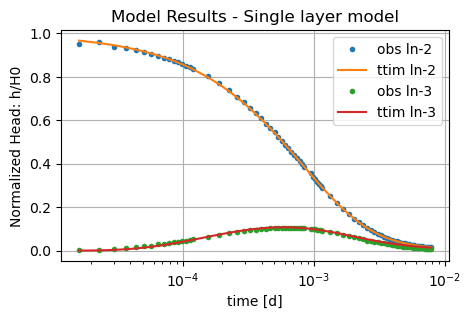

In [9]:
hm1_0 = ml_0.head(0, 0, t1, layers=0)
hm2_0 = ml_0.head(r, 0, t2, layers=0)
plt.semilogx(t1, h1 / H0, ".", label="obs ln-2")
plt.semilogx(t1, hm1_0[0] / H0, label="ttim ln-2")
plt.semilogx(t2, h2 / H0, ".", label="obs ln-3")
plt.semilogx(t2, hm2_0[0] / H0, label="ttim ln-3")
plt.xlabel("time [d]")
plt.ylabel("Normalized Head: h/H0")
plt.title("Model Results - Single layer model")
plt.legend()
plt.grid()

In general, the single-layer model seems to be performing well, with a good visual fit between observations and the model.

## Step 8. Calibration with well skin resistance

Now we test if the skin resistance of the well has an impact on model calibration. Therefore, we add the ```res``` parameter in the calibration settings. We use the one-layer model.

In [10]:
# unknown parameters: kaq, Saq, res
ca_1 = Calibrate(ml_0)
ca_1.set_parameter(name="kaq0", initial=10)
ca_1.set_parameter(name="Saq0", initial=1e-4)
ca_1.set_parameter_by_reference(name="res", parameter=w_0.res, initial=0)
ca_1.series(name="Ln-2", x=0, y=0, layer=0, t=t1, h=h1)
ca_1.series(name="Ln-3", x=r, y=0, layer=0, t=t2, h=h2)
ca_1.fit(report=True)

...............................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 60
    # data points      = 162
    # variables        = 3
    chi-square         = 0.01690846
    reduced chi-square = 1.0634e-04
    Akaike info crit   = -1479.14110
    Bayesian info crit = -1469.87831
[[Variables]]
    kaq0:  1.16576542 +/- 0.00294637 (0.25%) (init = 10)
    Saq0:  9.3658e-06 +/- 1.1758e-07 (1.26%) (init = 0.0001)
    res:   3.2223e-04 +/- 3.7606e-04 (116.71%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.4716
    C(Saq0, res)  = -0.1735
    C(kaq0, res)  = -0.1123


In [11]:
display(ca_1.parameters)
print("RMSE:", ca_1.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,1.165765,2.946366e-03,0.252741,-inf,inf,10.0000,[1.1657654176844345]
Saq0,0.000009,1.175825e-07,1.255447,-inf,inf,0.0001,[9.365789753052068e-06]
res,0.000322,3.760613e-04,116.706432,-inf,inf,0.0000,[0.00032222841263507024]


RMSE: 0.0102163200188728


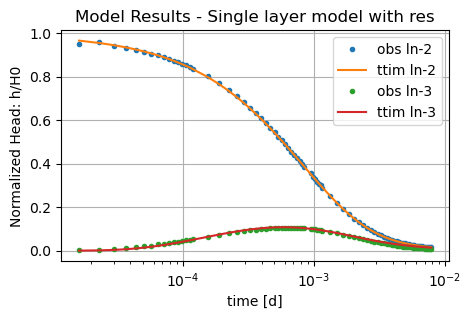

In [12]:
hm1_1 = ml_0.head(0, 0, t1, layers=0)
hm2_1 = ml_0.head(r, 0, t2, layers=0)
plt.semilogx(t1, h1 / H0, ".", label="obs ln-2")
plt.semilogx(t1, hm1_1[0] / H0, label="ttim ln-2")
plt.semilogx(t2, h2 / H0, ".", label="obs ln-3")
plt.semilogx(t2, hm2_1[0] / H0, label="ttim ln-3")
plt.xlabel("time [d]")
plt.ylabel("Normalized Head: h/H0")
plt.title("Model Results - Single layer model with res")
plt.legend()
plt.grid()

Adding well screen resistance does not improve the performance significantly, while the AIC value increases. Thus, it is recommended to leave it out of the model.

## Step 9. Create Second Model - multi-layer model

We will create a multi-layer model to investigate whether we can improve the model performance if we account for the vertical flow component. We carry this out by dividing the previous aquifer into 0.5 m thick layers.

In [13]:
# Determine elevations of each layer.
# Thickness of each layer is set to be 0.5 m.
z = np.arange(0, b, -0.5)
zlay = np.append(z, b)
nlay = len(zlay) - 1
Saq_2 = 1e-4 * np.ones(nlay)
n = np.arange(0, 13, 1)

Now we use the ```Model3D``` object to model multi-layer aquifer:

Details on how to set it up can be seen in the notebook: [Unconfined - 1 - Vennebulten](unconfined1_vennebulten.ipynb)

In [14]:
ml_2 = Model3D(
    kaq=10, z=zlay, Saq=Saq_2, kzoverkh=1, tmin=1e-5, tmax=0.01, phreatictop=True
)
w_2 = Well(ml_2, xw=0, yw=0, rw=rw1, tsandQ=[(0, -Q)], layers=n, rc=rc1, wbstype="slug")
ml_2.solve()

self.neq  13
solution complete


## Step 10. Calibration of multi-layer model

In [15]:
ca_2 = Calibrate(ml_2)
ca_2.set_parameter(name="kaq0_12", initial=10)
ca_2.set_parameter(name="Saq0_12", initial=1e-4, pmin=0)
ca_2.series(name="Ln-2", x=0, y=0, layer=0, t=t1, h=h1)
ca_2.series(name="Ln-3", x=r, y=0, layer=0, t=t2, h=h2)
ca_2.fit(report=True)

..............................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 162
    # variables        = 2
    chi-square         = 0.02007628
    reduced chi-square = 1.2548e-04
    Akaike info crit   = -1453.32163
    Bayesian info crit = -1447.14643
[[Variables]]
    kaq0_12:  1.17007319 +/- 0.00316534 (0.27%) (init = 10)
    Saq0_12:  8.4528e-06 +/- 1.1200e-07 (1.33%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0_12, Saq0_12) = -0.4774


In [16]:
display(ca_2.parameters)
print("RMSE:", ca_2.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_12,1.170073,3.165339e-03,0.270525,-inf,inf,10.0000,"[1.170073186863713, 1.170073186863713, 1.17007..."
Saq0_12,0.000008,1.120027e-07,1.325044,0.0,inf,0.0001,"[8.452751493193134e-06, 8.452751493193134e-06,..."


RMSE: 0.011132280289157479


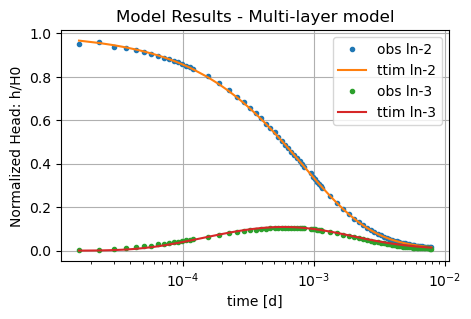

In [17]:
hm1_2 = ml_2.head(0, 0, t1, layers=n)
hm2_2 = ml_2.head(r, 0, t2, layers=n)
plt.semilogx(t1, h1 / H0, ".", label="obs ln-2")
plt.semilogx(t1, hm1_2[0] / H0, label="ttim ln-2")
plt.semilogx(t2, h2 / H0, ".", label="obs ln-3")
plt.semilogx(t2, hm2_2[0] / H0, label="ttim ln-3")
plt.xlabel("time [d]")
plt.ylabel("Normalized Head: h/H0")
plt.title("Model Results - Multi-layer model")
plt.legend()
plt.grid()

The new model showed similar parameters and RMSE values compared to the previous single-layer model. However, the AIC value was much smaller.

## Step 11. Analysis and comparison of simulated values

We now compare the values in TTim and also add the results of the modelling done in AQTESOLV and MLU by Yang (2020).

In [18]:
ta = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]"],
    index=["MLU", "AQTESOLV", "ttim-single", "ttim-multi"],
)
ta.loc["AQTESOLV"] = [1.166, 9.368e-06]
ta.loc["MLU"] = [1.311, 8.197e-06]
ta.loc["ttim-single"] = ca_0.parameters["optimal"].values
ta.loc["ttim-multi"] = ca_2.parameters["optimal"].values
ta["RMSE"] = [0.010373, 0.009151, ca_0.rmse(), ca_2.rmse()]
ta.style.set_caption("Comparison of parameter values and error under different models")

,k [m/d],Ss [1/m],RMSE
MLU,1.311000,0.000008,0.010373
AQTESOLV,1.166000,0.000009,0.009151
ttim-single,1.166107,0.000009,0.010219
ttim-multi,1.170073,0.000008,0.011132


The parameters in every model closely match each other. The error was also very similar.

## References

* Butler, J.J., Jr., 1998. The Design, Performance, and Analysis of Slug Tests, Lewis Publishers, Boca Raton, Florida, 252p.
* Hyder, Z., Butler Jr, J.J., McElwee, C.D., Liu, W., 1994. Slug tests in partially penetrating wells. Water Resources Research 30, 2945–2957.
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.